# Compute the Roc curve from the different features

Here we compute the ROC curve from different features.

## Import libraries

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
import feather
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, auc
import tensorflow as tf
import keras
from keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Reshape, GRU, Permute

## Load the data from GLM results

Here we have the results of the GLM model using the IEA backhistory and the Seizures backhistory.

In [2]:
results=feather.read_dataframe(r'data/all_patients_ts_test_day_acausal4.feather')
results

patient      score_method  preds_test  test_Sz  cov_test_IEA   time  \
0       None              None         NaN      NaN           NaN    NaN   
1         BJ  prop_time_corr_1    0.127896      0.0     -0.687848    1.0   
2         BJ  prop_time_corr_1    0.229434      0.0     -0.379885    2.0   
3         BJ  prop_time_corr_1    0.371381      0.0     -0.071923    3.0   
4         BJ  prop_time_corr_1    0.099135      1.0     -0.482539    4.0   
...      ...               ...         ...      ...           ...    ...   
8382      WP  prop_time_corr_1    0.262944      0.0     -0.211298  553.0   
8383      WP  prop_time_corr_1    0.337132      0.0     -0.285971  554.0   
8384      WP  prop_time_corr_1    0.387617      0.0     -0.565994  555.0   
8385      WP  prop_time_corr_1    0.387617      1.0     -0.547326  556.0   
8386      WP  prop_time_corr_1    0.598389      0.0      0.498094  557.0   

      cov_choice  
0           None  
1     only_cross  
2     only_cross  
3     only_cross  
4     only_cross  
...          ...  
8382   only_auto  
8383   only_auto  
8384   only_auto  
8385   only_auto  
8386   only_auto  

[8387 rows x 7 columns]

Select a given patient for two different covariates

In [3]:
InxPat_IEA=np.where((results.patient == 'JE') 
                    & (results.cov_choice == 'only_cross'))
InxPat_Seiz=np.where((results.patient == 'JE') 
                     & (results.cov_choice == 'only_auto'))

Take the Prediction and seizures of each covariate

In [4]:
Prediction_IEA=results.preds_test.iloc[InxPat_IEA].to_numpy()
Prediction_Seiz=results.preds_test.iloc[InxPat_Seiz].to_numpy()

Seizures_IEA=results.test_Sz.iloc[InxPat_IEA].to_numpy()
Seizures_Seiz=results.test_Sz.iloc[InxPat_Seiz].to_numpy()

InxS_IEA=np.where(Seizures_IEA>=1)
InxS_Seiz=np.where(Seizures_Seiz>=1)

Plot the Covariates with the seizures

Note that even that visualy the IEA seems to do better, we need to set a quantification measure to access our visual intuition. 

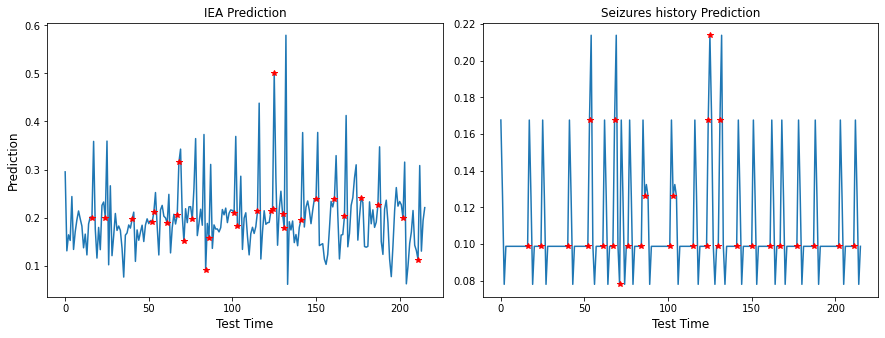

In [6]:
fig, axs = plt.subplots(1, 2,figsize=(12.4, 4.8))
axs[0].set_xlabel('Test Time',fontsize=12)
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(Prediction_IEA)
axs[0].plot(InxS_IEA[0],Prediction_IEA[InxS_IEA],'r*')
axs[0].set_title('IEA Prediction')
axs[1].set_title('Seizures history Prediction')
axs[1].plot(Prediction_Seiz)
axs[1].plot(InxS_Seiz[0],Prediction_Seiz[InxS_Seiz],'r*')
axs[1].set_xlabel('Test Time',fontsize=12)

plt.tight_layout()
plt.show()

### We calcualte the ROC curve

We do it for both the predictions. We first need to compute:

    - Sensitivity(TPR): proportion of seizures correctly identified
    - Specificity: proportion of non seizures days correctly identified. We plot 1-Specificity (FPR)

In [7]:
fpr_IEA, tpr_IEA, thresholds_keras = roc_curve(Seizures_IEA, Prediction_IEA)
auroc_IEA = auc(fpr_IEA, tpr_IEA)
fpr_S, tpr_S, thresholds_keras = roc_curve(Seizures_Seiz, Prediction_Seiz)
auroc_Seiz = auc(fpr_S, tpr_S)
print('Auroc using the IEA model of prediction = %0.2f' %auroc_IEA)
print('Auroc using the Seizure history model of prediction = %0.2f' %auroc_Seiz)

Auroc using the IEA model of prediction = 0.59
Auroc using the Seizure history model of prediction = 0.54


### ROC Curve

We plot FPR vs TPR. The area under the ROC curve (AUROC) tells us how good or bad our classification is.

    - AUROC=0.5 marks a random classification.
    - AUROC=1 a threshold exists in which we can perfectly separate the Seizures and non seizures days.



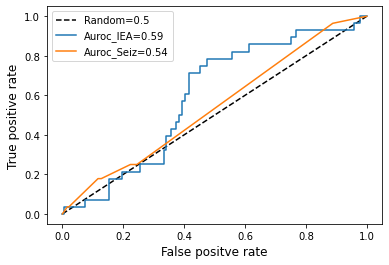

In [9]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA,label='Keras (area = {:.3f})'.format(auroc_IEA))
plt.plot(fpr_S, tpr_S, label='Keras (area = {:.3f})'.format(auroc_Seiz))
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random=0.5','Auroc_IEA=%0.2f' %(auroc_IEA),'Auroc_Seiz=%0.2f' %(auroc_Seiz)])
plt.show()

Note that indeed the IEA is better than the history of Seizures as a predictor. Still, the values are close to 0.5 which are not great classifications

### Results of the Multidien cycle
Here we have the results of the GLM model using the Multidien phase (cos(Phase) + Sin(Phase)) as a covariates. 

In [10]:
results=feather.read_dataframe(r'data/all_patients_no_cross_auto_ts_test_day_acausal4.feather')
results

patient      score_method  preds_test  test_Sz  cov_test_IEA   time  \
0       None              None         NaN      NaN           NaN    NaN   
1         BJ  prop_time_corr_1    0.140870      0.0     -0.482539    1.0   
2         BJ  prop_time_corr_1    0.119790      0.0     -0.379885    2.0   
3         BJ  prop_time_corr_1    0.121372      0.0     -0.687848    3.0   
4         BJ  prop_time_corr_1    0.144757      0.0     -0.379885    4.0   
...      ...               ...         ...      ...           ...    ...   
8454      WP  prop_time_corr_1    0.707840      0.0     -0.211298  555.0   
8455      WP  prop_time_corr_1    0.708469      0.0     -0.285971  556.0   
8456      WP  prop_time_corr_1    0.611408      0.0     -0.565994  557.0   
8457      WP  prop_time_corr_1    0.465036      1.0     -0.547326  558.0   
8458      WP  prop_time_corr_1    0.326436      0.0      0.498094  559.0   

       cov_choice  
0            None  
1       week_hist  
2       week_hist  
3       week_hist  
4       week_hist  
...           ...  
8454  phase_multi  
8455  phase_multi  
8456  phase_multi  
8457  phase_multi  
8458  phase_multi  

[8459 rows x 7 columns]

As before, we take the prediction of the GLM model based on the multidien phase. 

In [13]:
InxPat_Multi=np.where((results.patient == 'JE') 
                    & (results.cov_choice == 'phase_multi'))
Prediction_Multi=results.preds_test.iloc[InxPat_Multi].to_numpy()
Seizures_M=results.test_Sz.iloc[InxPat_Multi].to_numpy()

We plot the prediction with the Seizures

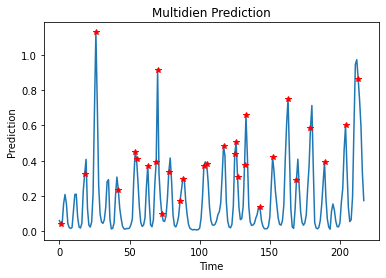

In [20]:
InxS_M=np.where(Seizures_M>=1)
plt.figure()
plt.plot(Prediction_Multi)
plt.plot(InxS_M[0],Prediction_Multi[InxS_M],'r*')
plt.title('Multidien Prediction')
plt.xlabel('Time')
plt.ylabel('Prediction')
plt.show()

Calculate FPR and TPR

In [23]:
fpr_M, tpr_M, thresholds_keras = roc_curve(Seizures_M, Prediction_Multi)
auroc_M = auc(fpr_M, tpr_M)
auroc_M

0.8691844553913519

### Plot ROC curve of the Multidien prediction

We plot the ROC curve for the multidien prediction along with the others covariates

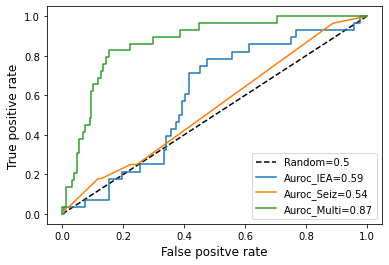

In [24]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA)
plt.plot(fpr_S, tpr_S)
plt.plot(fpr_M, tpr_M)

plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random=0.5','Auroc_IEA=%0.2f' %(auroc_IEA),'Auroc_Seiz=%0.2f' %(auroc_Seiz),'Auroc_Multi=%0.2f' %(auroc_M)])
plt.show()

We cleary see that the Multidien phase is much better predictor that both the IEA and the Seiz history.

### Surrogates

We just saw that for the IEA and the Seiz history, the AUROC are very close to the random behavior. To see if these covariates are indeed predictors or not, we compare their AUROC's results with surrogates. In our case we randomly shift the prediction and compute the AUROC of the shifted time series

In [25]:
Prediction_IEA_surro=np.random.permutation(Prediction_IEA)
Prediction_Seiz_surro=np.random.permutation(Prediction_Seiz)


Plot the Surrogate of the IEA with the real prediction

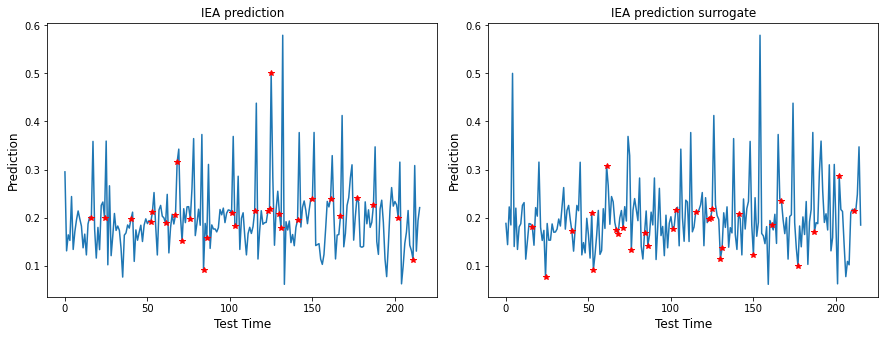

In [27]:
fig, axs = plt.subplots(1, 2,figsize=(12.4, 4.8))
axs[0].set_xlabel('Test Time',fontsize=12)
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(Prediction_IEA)
axs[0].plot(InxS_IEA[0],Prediction_IEA[InxS_IEA],'r*')
axs[0].set_title('IEA prediction')
plt.xlabel('Test Time',fontsize=12)
plt.ylabel('Prediction',fontsize=12)
axs[1].set_title('IEA prediction surrogate')
axs[1].plot(Prediction_IEA_surro)
axs[1].plot(InxS_IEA[0],Prediction_IEA_surro[InxS_IEA],'r*')
axs[1].set_xlabel('Test Time',fontsize=12)
plt.tight_layout()
plt.show()

From these plots its difficult to see whether the original prediction or the surrogate one is better.

Let's do the same for the Seizure history prediction


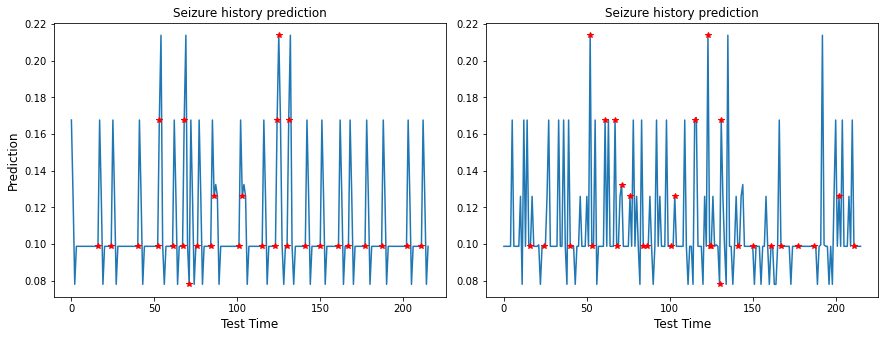

In [28]:
fig, axs = plt.subplots(1, 2,figsize=(12.4, 4.8))
axs[0].set_xlabel('Test Time',fontsize=12)
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(Prediction_Seiz)
axs[0].plot(InxS_Seiz[0],Prediction_Seiz[InxS_Seiz],'r*')
axs[0].set_title('Seizure history prediction')
axs[1].set_title('Seizure history prediction')
axs[1].plot(Prediction_Seiz_surro)
axs[1].plot(InxS_Seiz[0],Prediction_Seiz_surro[InxS_Seiz],'r*')
axs[1].set_xlabel('Test Time',fontsize=12)
plt.tight_layout()
plt.show()

Plot the surrogate Roc against the original one. 

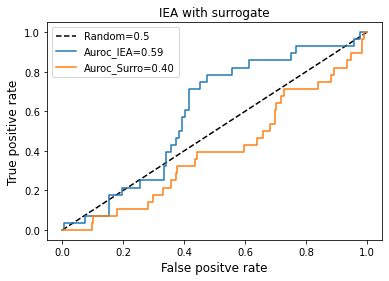

In [29]:
fpr_IEA_su, tpr_IEA_su, thresholds_keras = roc_curve(Seizures_IEA, Prediction_IEA_surro)
auroc_IEA_su = auc(fpr_IEA_su, tpr_IEA_su)
plt.figure()
plt.title('IEA with surrogate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA)
plt.plot(fpr_IEA_su, tpr_IEA_su)
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random=0.5','Auroc_IEA=%0.2f' %(auroc_IEA),'Auroc_Surro=%0.2f' %(auroc_IEA_su)])
plt.show()

Same for the Seiz history surrogates

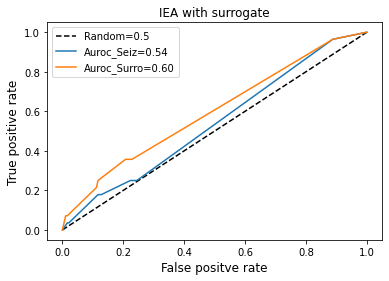

In [30]:
fpr_S_su, tpr_S_su, thresholds_keras = roc_curve(Seizures_Seiz, Prediction_Seiz_surro)
auroc_Seiz_su = auc(fpr_S_su, tpr_S_su)
plt.figure()
plt.title('IEA with surrogate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_S, tpr_S)
plt.plot(fpr_S_su, tpr_S_su)
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random=0.5','Auroc_Seiz=%0.2f' %(auroc_Seiz),'Auroc_Surro=%0.2f' %(auroc_Seiz_su)])
plt.show()

In this case it is even clear that the surrogates have similar prediction power than the original prediction.

## Simulated data

We simulate both the IEA and the Seizures with a Poisson process with a periodic lambda.

Define the variables

In [31]:
dt = 1/24
T = 10000
t = np.arange(0,T,dt)
N=len(t)
lam = np.zeros(shape=(N,1))
lam_seiz = np.zeros(shape=(N,1))
Y = np.zeros(shape=(N,1))
Y_Seiz = np.zeros(shape=(N,1))
X = np.zeros(shape=(N,1))
X_Seiz = np.zeros(shape=(N,1))

We define the underlying rhythm as a cosinus with a fixed period of P=30. In our first model, both underlying rhythms, IEA (X) and Seizures (X_Seiz) share the same periodicity. The phase-shift indicates the shift between the IEA and Seizures.

In [32]:
Phase_shift=0.5*math.pi
nchanges=round(T/500)
step=24*500
ini=0  
fin=step
Period=30   ## this I commented if we want or not to have variable period
#for i in range(nchanges):
#    Period=round(np.random.uniform(4,45))
#    Period=30
#    X[ini:fin,0] = np.cos((2*math.pi/(Period))*t[ini:fin])
#    X_Seiz[ini:fin,0]=np.cos(Phase_shift+(2*math.pi/(Period))*t[ini:fin])
#    ini=ini+step
#    fin=fin+step
X[:,0]=np.cos((2*math.pi/(Period))*t[:])
X_Seiz[:,0]=np.cos(math.pi+(2*math.pi/(Period))*t[:])

We plot the underlying rhythm to se how it looks like.

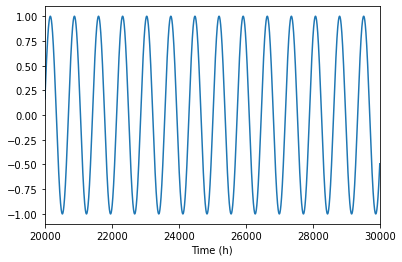

In [33]:
plt.figure()
plt.plot(X)
plt.xlim([20000,30000])
plt.xlabel('Time (h)')
plt.show()

### Model parameters

We have several parameters that control the model:
   - Baseline: baseline IEA, the more the less important is the IEA cycle
   - IEALevel: strength of the IEA cycle.
   - SeizureLevel: same as above but for seizures
   - NoiseSeiz: to make seizures appear independently of the underlying cycle.

Both IEA and Seizure generated based on a poisson process with a lambda as the underlying rhythm we just defined

In [34]:

randomN=np.random.uniform(size=(N,3))
BaselineSeiz=3 
NoiseSeiz=0
Noise=1
IEALevel=4.5
SeizureLevel=4.5
for i in range(N):               
    lam[i] = np.exp(-4.5 +  IEALevel*X[i])/dt+BaselineSeiz
    lam_seiz[i]= np.exp(-4.5 +  SeizureLevel*X_Seiz[i])
    p = lam[i]*dt 
    p_seiz=lam_seiz[i]*dt+NoiseSeiz*randomN[i,2]
    if p > randomN[i,0]:
        Y[i]=1 
    if p_seiz > randomN[i,1]:    
        Y_Seiz[i]=1

Put the data in "daily" counts and normalize

In [35]:
IEA=Y.reshape(T,24)
Seiz=Y_Seiz.reshape(T,24)
Real_risk=lam_seiz.reshape(T,24)
IEA=np.sum(IEA,1)
Seiz=np.sum(Seiz,1)
Real_risk=np.mean(Real_risk,1)
# noise in the counts
IEA=IEA+Noise*np.random.uniform(size=(IEA.shape[0]))
mean_IEA, std_IEA = np.mean(IEA, 0), np.std(IEA, 0)
IEA = (IEA - mean_IEA)/std_IEA
Seiz[np.where(Seiz>1)]=1
PosSeiz=np.where(Seiz==1)
print('Nº Seiz %0.0f' %len(PosSeiz[0]))

Nº Seiz 1421


Plot the data. No the the Seizure risk shift to the IEA

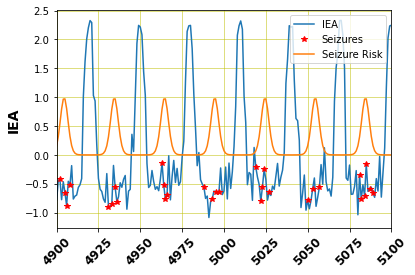

In [36]:
tt=t[::24]
plt.figure()
plt.plot(tt,IEA)
plt.plot(tt[PosSeiz],IEA[PosSeiz],'r*')
plt.plot(tt,Real_risk)
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.xlim((4900, 5100))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['IEA','Seizures','Seizure Risk'])
plt.show()

### Compute and plot the ROC curve

To simplyfy, we take the real risk as the predictor

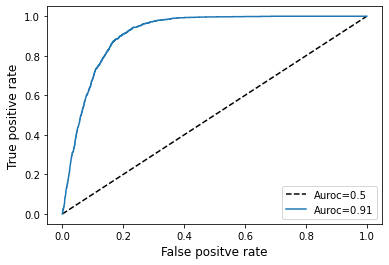

In [39]:
fpr, tpr, thresholds_keras = roc_curve(Seiz, Real_risk)
auroc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
plt.legend(['Auroc=0.5','Auroc=%0.2f' %(auroc)])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.show()

### Unbalanced time series  Here its not completely done, I have to think more which is the bests examples to put

What happens if in our model, the number of seizures are less frequent?Or if we have seizures that not follow the 

In [40]:

Period=50
X[:,0]=np.cos((2*math.pi/(Period))*t[:])
X_Seiz[:,0]=np.cos(math.pi+(2*math.pi/(Period))*t[:])

randomN=np.random.uniform(size=(N,3))
BaselineSeiz=3 
NoiseSeiz=0
Noise=1
IEALevel=4.5
SeizureLevel=4.5
for i in range(N):               
    lam[i] = np.exp(-4.5 +  IEALevel*X[i])/dt+BaselineSeiz
    lam_seiz[i]= np.exp(-4.5 +  SeizureLevel*X_Seiz[i])
    p = lam[i]*dt 
    p_seiz=lam_seiz[i]*dt+NoiseSeiz*randomN[i,2]
    if p > randomN[i,0]:
        Y[i]=1 
    if p_seiz > randomN[i,1]:    
        Y_Seiz[i]=1

We do all the steps again

In [41]:
IEA=Y.reshape(T,24)
Seiz=Y_Seiz.reshape(T,24)
Real_risk=lam_seiz.reshape(T,24)
IEA=np.sum(IEA,1)
Seiz=np.sum(Seiz,1)
Real_risk=np.mean(Real_risk,1)
# noise in the counts
IEA=IEA+Noise*np.random.uniform(size=(IEA.shape[0]))
mean_IEA, std_IEA = np.mean(IEA, 0), np.std(IEA, 0)
IEA = (IEA - mean_IEA)/std_IEA
Seiz[np.where(Seiz>1)]=1
PosSeiz=np.where(Seiz==1)
print('Nº Seiz %0.0f' %len(PosSeiz[0]))

Nº Seiz 2695


Let's plot the risk and the seziures again

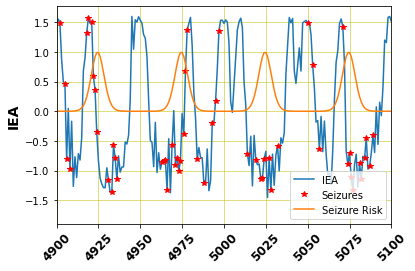

In [42]:
tt=t[::24]
plt.figure()
plt.plot(tt,IEA)
plt.plot(tt[PosSeiz],IEA[PosSeiz],'r*')
plt.plot(tt,Real_risk)
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.xlim((4900, 5100))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['IEA','Seizures','Seizure Risk'])
plt.show()

What happens to the ROC curve

In [ ]:
fpr, tpr, thresholds_keras = roc_curve(Seiz, Real_risk)
auroc = auc(fpr, tpr)
inseiz=np.where(y_test == 1)
numS=len(inseiz[0])
print('Area under the ROC curve: %.2f' % auroc)
print('Length of the test set: %.0f Nº of seizures: %.0f' %(len(y_test),numS))
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
plt.legend(['Auroc=0.5','Auroc=%0.2f' %(auroc)])
plt.show()

The ROC curve is lower even if we use the real prediction as a predictor. Longer periods means longer proIctal and thus the Seizure probability extends on time. Whereas on a shorther period, the proIctal phase last less. ROC curve thus does not account on how faithful the prediction is accurate in a probabilistic level. It only accounts for the differences on the prediction score